In [1]:
%load_ext autoreload
import glob
import shutil
import nibabel
import pandas as pd
import numpy as np
import os
from IPython.core.debugger import set_trace
from datetime import datetime
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import notebook, tqdm
from joblib import Parallel, delayed
from tensorboardX import SummaryWriter  

import torchio as tio
import torchvision
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

import yaml
from easydict import EasyDict as edict

from utils import get_capacity, create_dicts, normalize, load, video, video_comparison, save, DiceScoreBinary, check_patch
from datasets import BrainMaskDataset

from multiprocessing import cpu_count
N_CPU = cpu_count()

from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

from IPython.core.display import display, HTML
from celluloid import Camera
from itertools import product

SEED = 42
%autoreload 2

# Visualization

In [2]:
logdir = './logs_BRATS_clf/resnet3d_ps32_BRATS_bs1_pbs16_clf0.5_fcd0.8_lr-1e-3_trim_GRID@02.02.2022-12:06:47/'

In [3]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [4]:
################
# CREATE MODEL #
################
# model = torchvision.models.video.r2plus1d_18(pretrained=False, progress=False) 
model = torchvision.models.video.r3d_18(pretrained=False, progress=False)
conv3d_1 = model.stem[0]

DEVICE = 0
device = torch.device(DEVICE)

# features
input_channels = 1
model.stem[0] = nn.Conv3d(in_channels=input_channels,
                         out_channels=conv3d_1.out_channels,
                         kernel_size=conv3d_1.kernel_size,
                         padding=conv3d_1.padding,
                         bias=conv3d_1.bias)

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)
model_capacity = get_capacity(model)
print(f'Model created! Capacity: {model_capacity}')

Model created! Capacity: 33.15


In [5]:
# model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights.pth'))
# print('LOADING from epoch:',model_dict['epoch'])
# model.load_state_dict(model_dict['model_state'])

In [17]:
config.dataset.root =  '/nfs/garfield/ibulygin/MICCAI_BraTS2020_TrainingData'

In [18]:
val_dataset_whole = BrainMaskDataset(config.dataset, train=False)
val_dataloader_whole = DataLoader(val_dataset_whole,
                                    batch_size=1,
                                    shuffle=False,
                                    collate_fn=None)

In [19]:
len(labels)

93

In [20]:
len(val_dataloader_whole)

93

In [21]:
config.dataset.fcd_threshold = 0.5

In [22]:
phase_name='val'
loss_name = config.opt.criterion
metric_dict = defaultdict(list)
patch_size = config.dataset.patch_size
patch_batch_size = config.dataset.patch_batch_size
batch_size = config.opt.val_batch_size
classification_threshold = config.model.classification_threshold
patch_fcd_threshold = config.dataset.fcd_threshold 
labels = val_dataloader_whole.dataset.labels
top_k_list = config.dataset.top_k_list if hasattr(config.dataset, 'top_k_list') else [10, 50, 100]
assert isinstance(top_k_list, list)

brains = []
predicted_segmentations = []
segmentations = []
dices = []
coverages=[]

with torch.no_grad():
    iterator = enumerate(val_dataloader_whole)

    # brain_tensor - [bs,C,H,W,D]
    # mask_tensor - [bs,1,H,W,D]
    # label_tensor - [bs,1,H,W,D]
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in iterator:

        #########################
        # SETUP GRID DATALOADER #
        #########################

        label = labels[iter_i]
        assert brain_tensor.shape[0] == 1
        n_fcd = label_tensor.sum()
        subject = tio.Subject(t1=tio.ScalarImage(tensor=brain_tensor[0]),
                              label=tio.LabelMap(tensor=label_tensor[0]),
                              n_fcd=n_fcd)

        patch_overlap = patch_size - (patch_size//4) # 0.75
        grid_sampler = tio.inference.GridSampler(
            subject, # validation subject
            patch_size,
            patch_overlap
        )

        patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=patch_batch_size)
        aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

        ########################
        # ITERATE OVER PATCHES #
        #############################################################################
        # number of FCD pixels in patch to be considered as FCD patch
        metric_dict_patch = defaultdict(list)
        targets_all = []
        probs_all = []
        preds_all = []

        for patch_i, patches_batch in tqdm(enumerate(patch_loader)):

            inputs = patches_batch['t1'][tio.DATA].to(device)  # [bs,C,p,p,p]
            targets = patches_batch['label'][tio.DATA].to(device) # [bs,1,p,p,p]
            n_fcd = patches_batch['n_fcd'].to(device).unsqueeze(1)

            targets_ = (targets.sum([-1,-2,-3]) / n_fcd) >= patch_fcd_threshold
            targets_ = targets_.type(torch.float32)

            logits = model(inputs)

            locations = patches_batch[tio.LOCATION]
            # casting back to patch
            outputs = torch.ones_like(targets)*logits[...,None,None,None].sigmoid() # [bs,1,p,p,p]
            aggregator.add_batch(outputs, locations)

            #####################
            # per-PATCH METRICS #
            #####################
            # map to and remove last dim
            targets_np = targets_.squeeze(-1).detach().cpu().numpy().astype(int) # [bs,]
            prob_pred_np = torch.sigmoid(logits.squeeze(-1)).detach().cpu().numpy() # [bs,]
            targets_pred_np = (prob_pred_np >= classification_threshold).astype(int)

            targets_all += list(targets_np)
            probs_all += list(prob_pred_np)
            preds_all += list(targets_pred_np)

        ##############################################################################
        class_balance = np.mean(targets_all)
        metric_dict['class_balance'].append(class_balance)
        if class_balance == 0:
            print(f'Class_balance for {label} is 0!')

        for k,v in metric_dict_patch.items():
            metric_dict[k].append(np.mean(v))

        targets_all=np.array(targets_all)
        probs_all=np.array(probs_all)
        preds_all=np.array(preds_all)

        accuracy = accuracy_score(targets_all, preds_all)
        precision = precision_score(targets_all, preds_all, zero_division=0)
        recall = recall_score(targets_all, preds_all, zero_division=0)
        roc_auc = roc_auc_score(targets_all, probs_all)
        f1 = f1_score(targets_all, preds_all, average='weighted')

        metric_dict['accuracy'].append(accuracy)
        metric_dict['precision'].append(precision)
        metric_dict['recall'].append(recall)
        metric_dict['roc_auc'].append(roc_auc)
        metric_dict['f1'].append(f1)

        ###########
        # HITRATE #
        ###########
        # sorting by predicted probabilities
        argsort = np.argsort(probs_all, axis=0)[::-1]
        for top_k in top_k_list:
            top_k_fcd = targets_all[argsort][:top_k]
            hitrate = top_k_fcd.mean() / top_k #((1./(np.arange(top_k)+1))*top_k_fcd).sum() 
            metric_dict[f'top-{top_k}_hitrate'].append(hitrate)

        ########
        # DICE #
        ########
        output_tensor = aggregator.get_output_tensor().unsqueeze(1) # [1,1,H,W,D]
        output_tensor = output_tensor * mask_tensor # zeros all non mask values
        dice = DiceScoreBinary(output_tensor, label_tensor).item()
        coverage = (output_tensor*label_tensor).sum() / label_tensor.sum()
        metric_dict['dice_score'].append(dice)
        metric_dict['coverage'].append(coverage.item())

        #########
        # PRINT #
        #########
        message = f'For {phase_name}, {label},'
        for title, value in metric_dict.items():
            v = np.round(value[-1],3)
            message+=f' {title}:{v}'
        print(message)

        brain = brain_tensor.detach().cpu().numpy()
        segmentation = label_tensor.detach().cpu().numpy()
        label_pred = output_tensor.detach().cpu().numpy()
        
        brains.append(brain)
        segmentations.append(label_tensor)
        predicted_segmentations.append(label_pred)
        dices.append(dice)
        coverages.append(coverage.item())

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/garfield/ibulygin/MICCAI_BraTS2020_TrainingData/tensor_071'

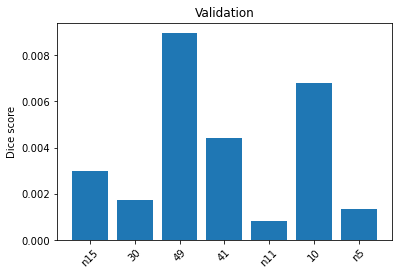

In [48]:
val_labels = val_dataset_whole.labels
plt.ion()
plt.figure()
plt.bar(val_labels, dices)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

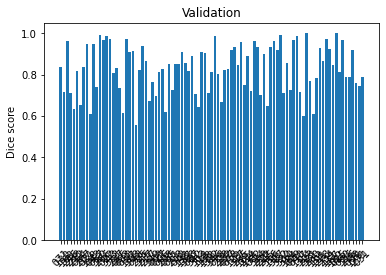

In [28]:
val_labels = val_dataset_whole.labels
plt.ion()
plt.figure()
plt.bar(val_labels, 1 - np.abs(np.random.randn(93)*0.2))
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

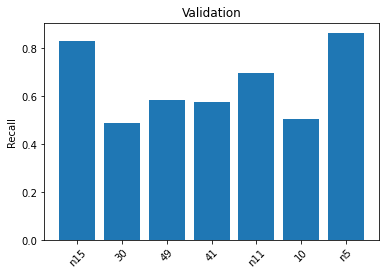

In [49]:
val_labels = val_dataset_whole.labels
plt.ion()
plt.figure()
plt.bar(val_labels, coverages)
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.show()

In [54]:
brains[ind][0].shape

(10, 183, 235, 199)

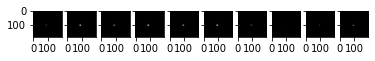

In [55]:
ind = np.argmax(coverages)
plt.ioff()
camera = video_comparison([brains[ind][0][i] for i in range (10)], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

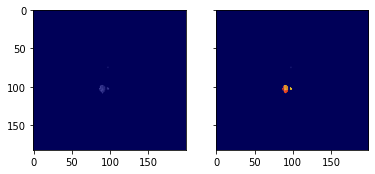

In [56]:
ind = np.argmax(coverages)
plt.ioff()
camera = video_comparison([brains[ind][0,2], brains[ind][0,2]], 
                          [segmentations[ind][0,0], predicted_segmentations[ind][0,0]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

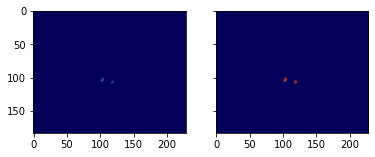

In [57]:
ind = np.argmax(dices)
plt.ioff()
camera = video_comparison([brains[ind][0,2], brains[ind][0,2]], 
                          [segmentations[ind][0,0], predicted_segmentations[ind][0,0]], 
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation